# PseudoBulk analysis to perform Differential Expression analysis

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd
import os
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata= ad.read_h5ad("/home/jiguo/data/data/anndata/adata_all_pp_cc.h5")
adata

AnnData object with n_obs × n_vars = 12572 × 11428
    obs: 'condition', 'replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'log', 'normalised', 'regress_cc'

In [3]:
adata.obs['sample'] = (
		adata.obs['condition'].astype(str) + '_' +
		adata.obs['replicate'].astype(str)
)
adata.X = adata.layers['counts'].copy()

In [4]:
pseudobulk_counts = pd.DataFrame(
		columns = adata.var_names,
		index = adata.obs['sample'].unique()
)

for sample in pseudobulk_counts.index:
		# Get cell indices for this sample
		sample_mask = adata.obs['sample'] == sample
		
		# Sum raw counts (use counts layer if available)
		if 'counts' in adata.layers:
				sample_counts = adata.layers['counts'][sample_mask].sum(axis=0)
		else:
				sample_counts = adata[sample_mask].X.sum(axis=0)
		
		#Handle sparse matrices
		if hasattr(sample_counts, 'A1'):
				pseudobulk_counts.loc[sample] = sample_counts.A1
		else:
				pseudobulk_counts.loc[sample] = sample_counts

In [5]:
pseudobulk_meta = adata.obs[
		['condition', 'replicate', 'sample']
].drop_duplicates().set_index('sample')

In [6]:
pseudobulk_adata = sc.AnnData(
    X=sparse.csr_matrix(pseudobulk_counts.fillna(0)),
    obs=pseudobulk_meta,
    var=adata.var
)

In [7]:
sc.pp.normalize_total(pseudobulk_adata, target_sum=1e6)  # CPM normalization
sc.pp.log1p(pseudobulk_adata)  # Log transform

In [8]:
sc.tl.rank_genes_groups(
		pseudobulk_adata,
		groupby='condition',
		method='t-test_overestim_var',
		use_raw=False
)

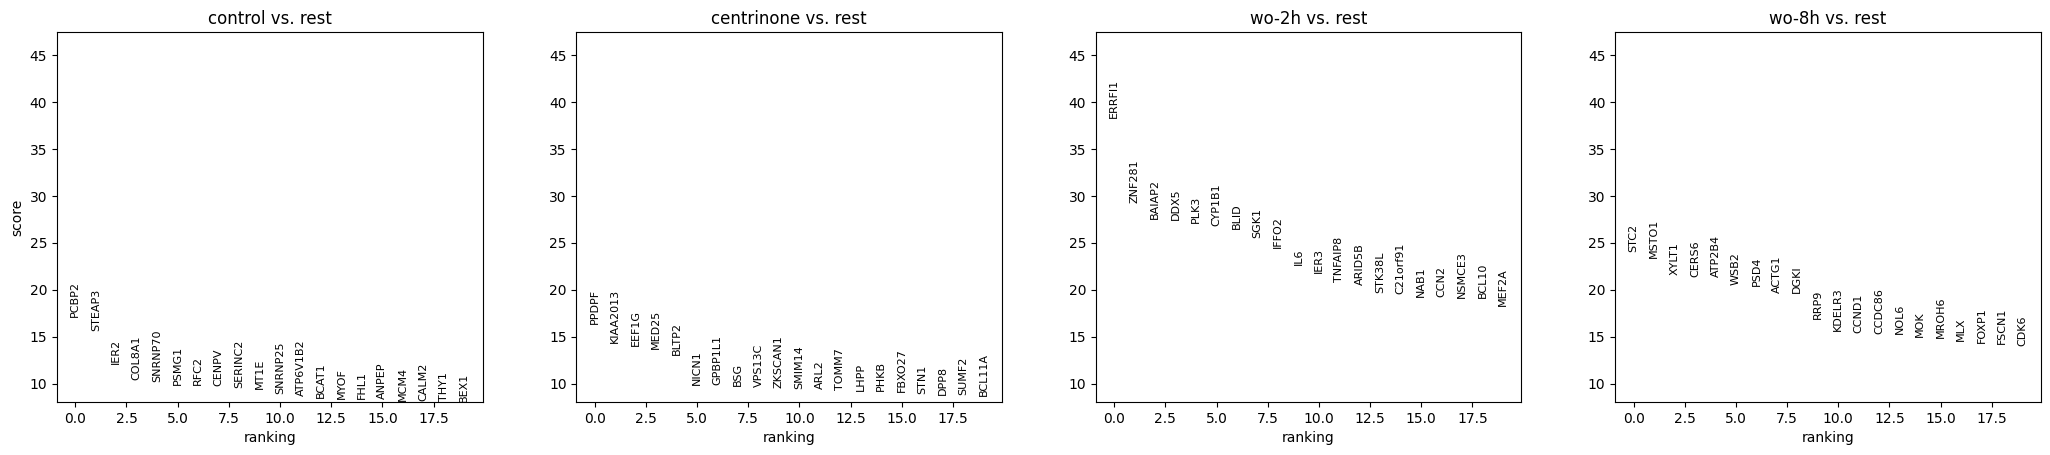

In [9]:
# 8. Visualization
sc.pl.rank_genes_groups(pseudobulk_adata, n_genes=20 )

In [10]:
# load 2 other list of genes related to mRNA processing and rRNA processing to label them in the volcano plot

def extract_de_results(adata, condition):
    # The input parameter 'condition' should be the CONTROL condition
    all_conditions = adata.obs['condition'].unique()
    control_condition = condition  # This is correct
    conditions = [c for c in all_conditions if c != control_condition]
    
    de_results = {}
    all_results_list = []  # To store all results for saving later
    for cond in conditions:
        # Should use the current adata parameter, not pseudobulk_adata
        de_df = sc.get.rank_genes_groups_df(
            adata,  # Fixed: use input adata
            group=cond,
            key='rank_genes_groups' 
        )
        de_df['-log10_pvals_adj'] = -np.log10(de_df['pvals_adj'])  # Use adjusted p-values
        de_df = de_df.merge(
            adata.var[['gene_name']],  # Fixed: use input adata
            left_on='names',
            right_index=True
        )
        # Add condition information
        de_df['comparison'] = f"{control_condition}_vs_{cond}"
        de_df['control'] = control_condition
        de_df['treatment'] = cond
        de_results[cond] = de_df
        all_results_list.append(de_df)
    # save the results to a file under the /home/jiguo/output/
    all_results_df = pd.concat(all_results_list)
    # Save to file
    output_file = f"/home/jiguo/output/pseudobulk_analysis/de_results_{control_condition}.csv"
    all_results_df.to_csv(output_file, index=False)
    print(f"DE results saved to {output_file} with condition information")
    return de_results, control_condition

def plot_volcano(de_results, control_condition):
    # Get conditions from de_results keys, not adata.obs
    conditions = list(de_results.keys())
    n_conditions = len(conditions)
    mRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/mRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    # Calculate grid dimensions
    n_cols = min(2, n_conditions)
    n_rows = (n_conditions + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 6*n_rows))
    sns.set(style='whitegrid', font_scale=1.2)
    
    for i, cond in enumerate(conditions, 1):
        df = de_results[cond]
        ax = plt.subplot(n_rows, n_cols, i)  # Fixed index: use i not i+1
        
        # Significance thresholds (use pvals_adj for FDR)
        sig_threshold = 0.05
        logfc_threshold = 1
        
        df['significance'] = 'Not significant'
        df.loc[(df['pvals_adj'] < sig_threshold) &  # Use ADJUSTED p-values
               (df['logfoldchanges'] > logfc_threshold), 'significance'] = 'Up-regulated'
        df.loc[(df['pvals_adj'] < sig_threshold) &  # Use ADJUSTED p-values
               (df['logfoldchanges'] < -logfc_threshold), 'significance'] = 'Down-regulated'
        

        sns.scatterplot(
            data=df,
            x='logfoldchanges',
            y='-log10_pvals_adj',  # Match the column name
            hue='significance',
            palette={'Up-regulated': '#e41a1c', 
                    'Down-regulated': '#377eb8',
                    'Not significant': '#bdbdbd'},
            alpha=0.7,
            s=40,
            ax=ax
                )
        # Gene labeling - better approach
        df['combined_score'] = np.abs(df['logfoldchanges']) * df['-log10_pvals_adj']
        top_genes = df.nlargest(10, 'combined_score')

        for _, row in top_genes.iterrows():
            ax.text(
                row['logfoldchanges'],
                row['-log10_pvals_adj'] + 0.1,  # Offset to avoid overlap
                row['gene_name'],
                fontsize=9,
                alpha=0.8,
                fontweight='bold'
            )
        
        # Add thresholds
        ax.axhline(-np.log10(sig_threshold), color='gray', linestyle='--', alpha=0.7)
        ax.axvline(logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        ax.axvline(-logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        
        # Correct title
        ax.set_title(f'{control_condition} vs {cond}', fontsize=16)  # Fixed title
        ax.set_xlabel('Log2 Fold Change', fontsize=14)
        ax.set_ylabel('-Log10(Adjusted p-value)', fontsize=14)
        ax.set_xlim(df['logfoldchanges'].min()-0.5, df['logfoldchanges'].max()+0.5)
        ax.legend().remove()  # Remove individual legends
    
    # Add common legend
    plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=3, 
                  bbox_to_anchor=(0.5, -0.05 if n_rows > 1 else -0.1))
    
    return plt

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_control.csv with condition information


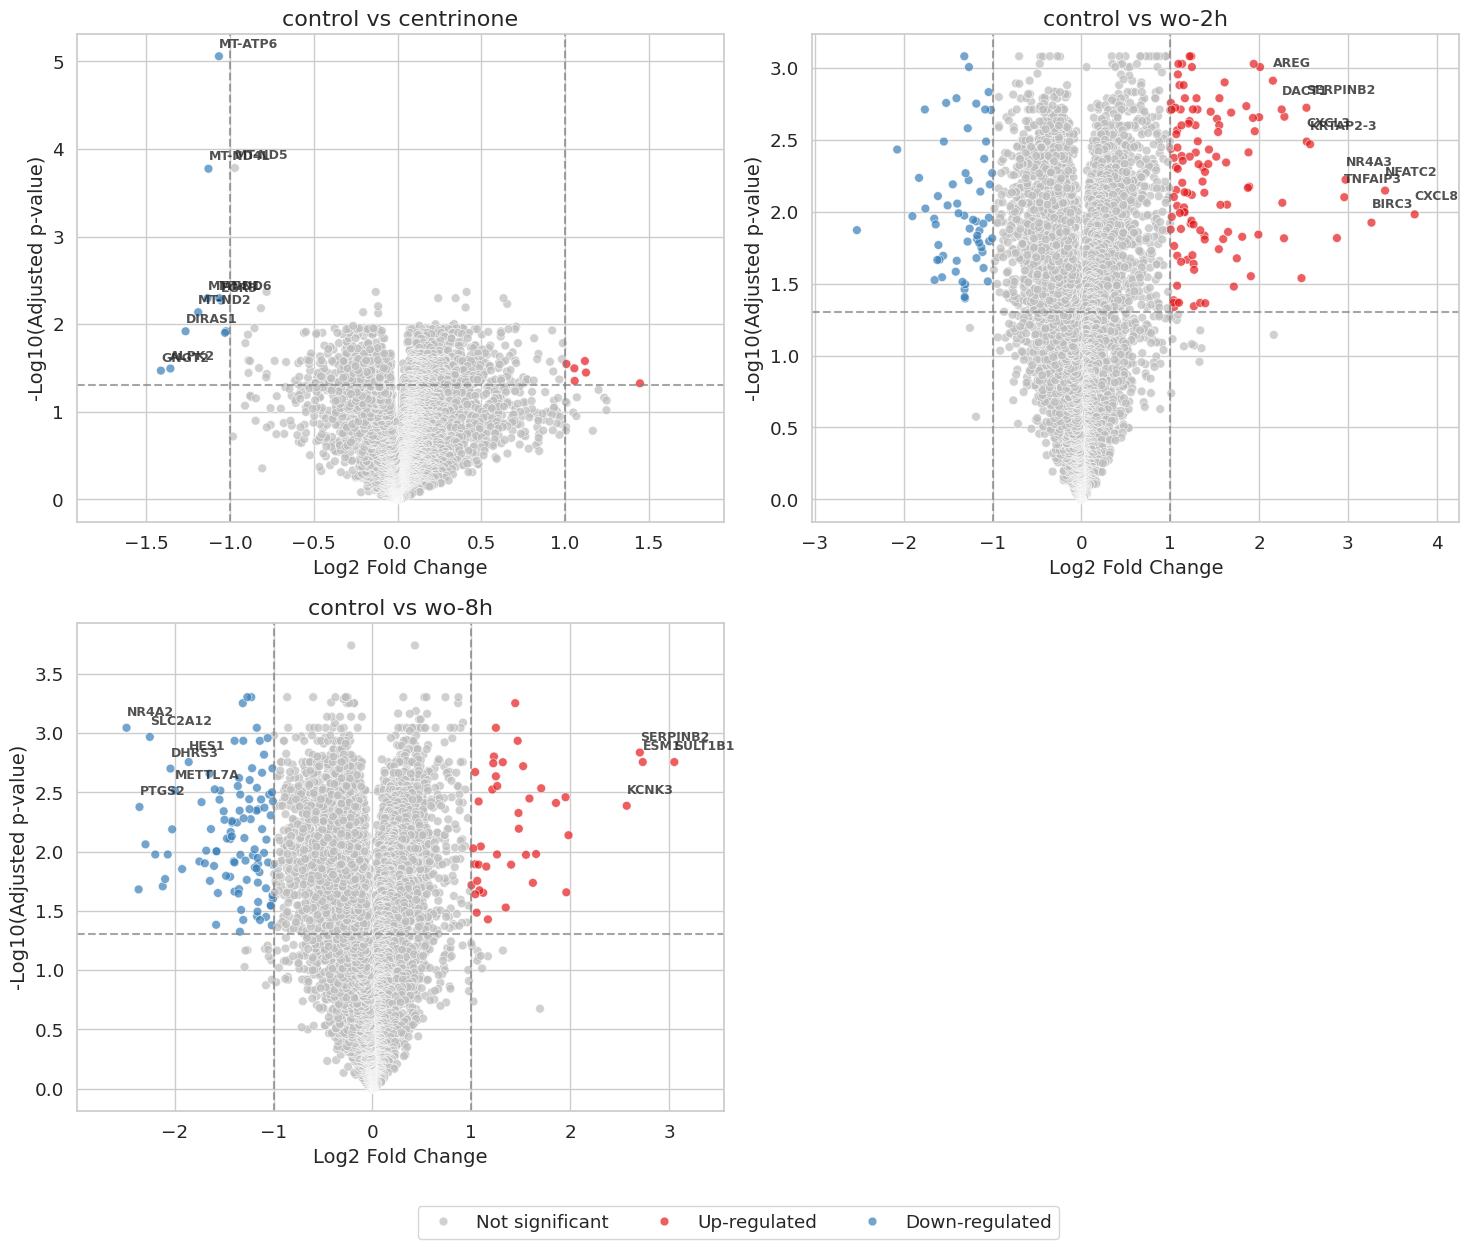

In [11]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='control',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='control'  # Specify control condition
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv with condition information


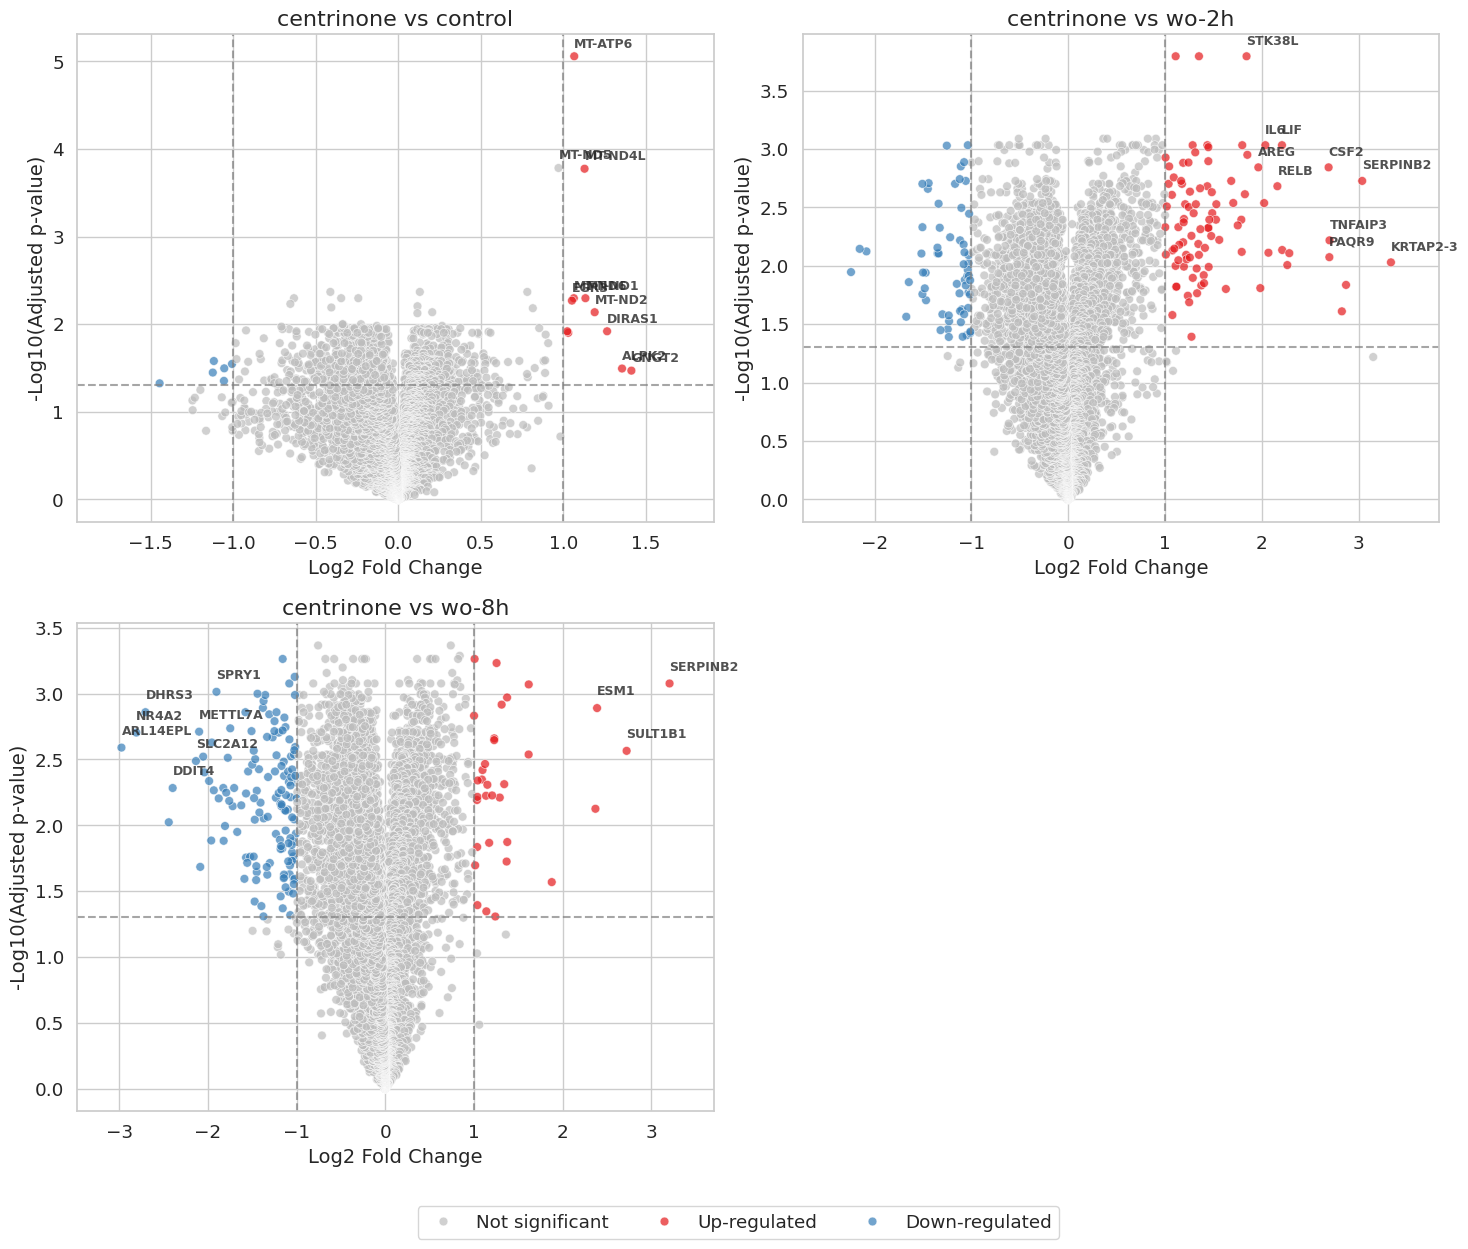

In [12]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='centrinone',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='centrinone'  # Specify control condition
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv with condition information


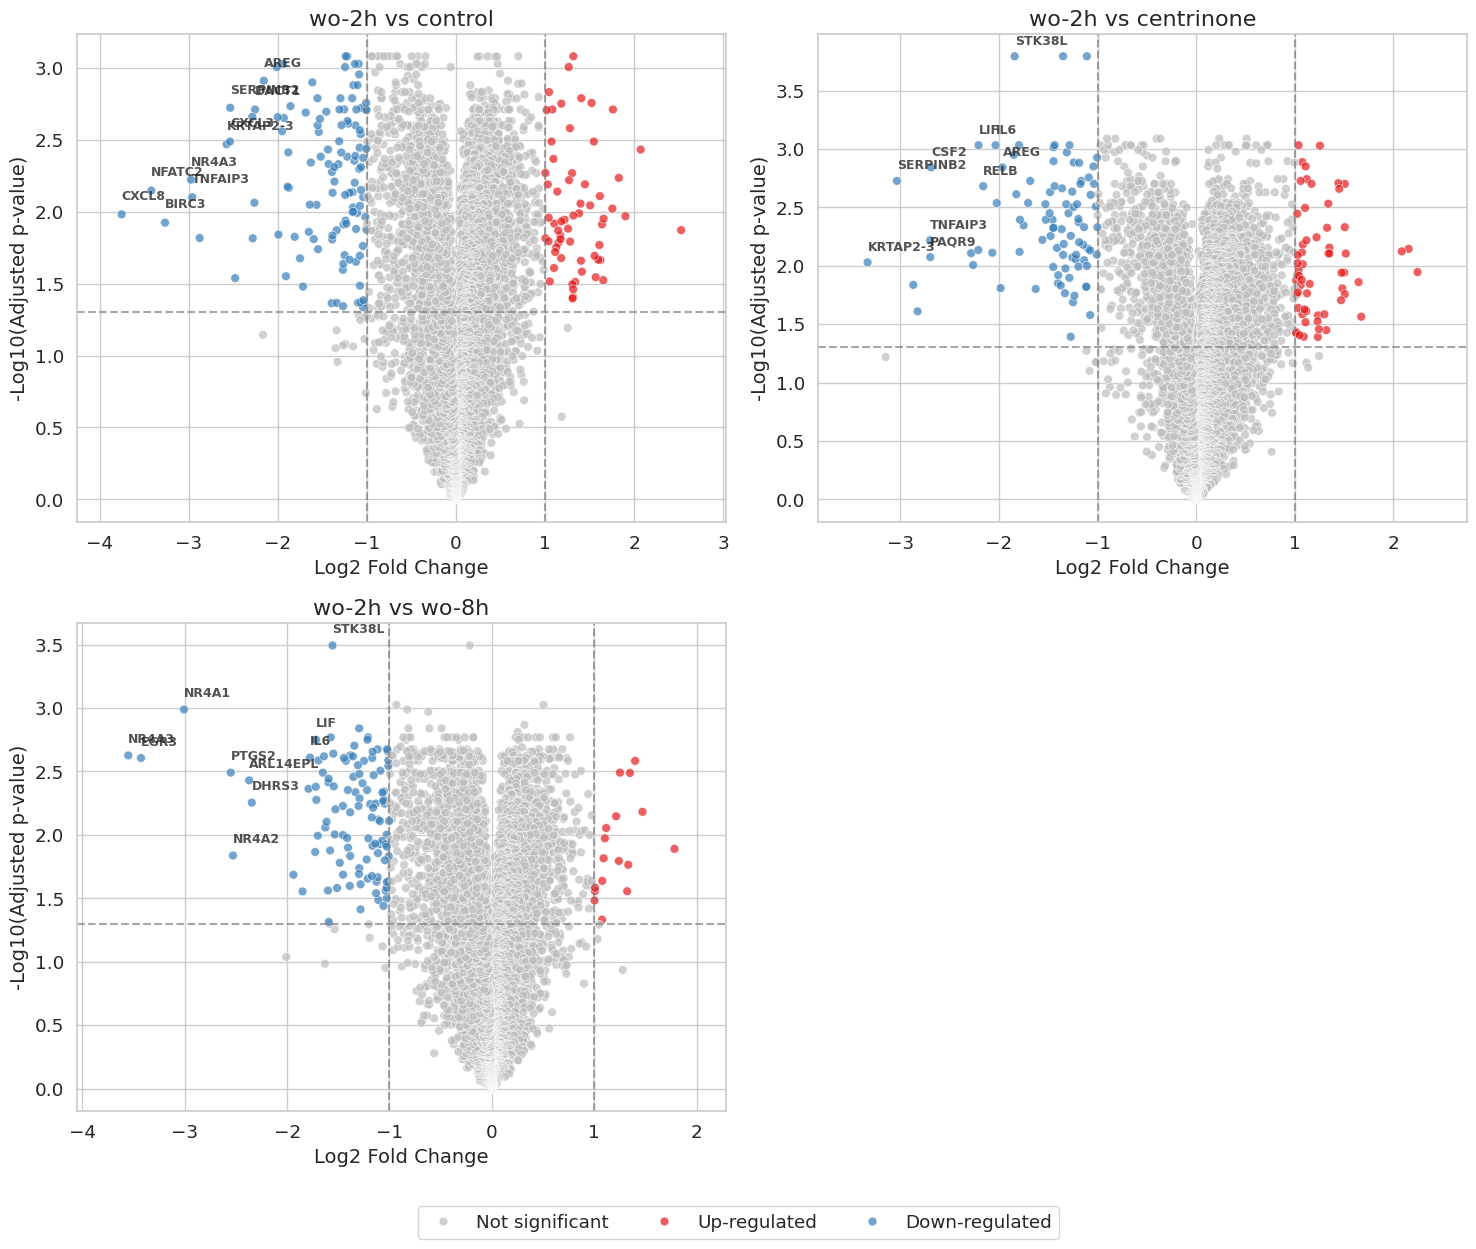

In [13]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='wo-2h',  
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='wo-2h'  
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_wo-8h.csv with condition information


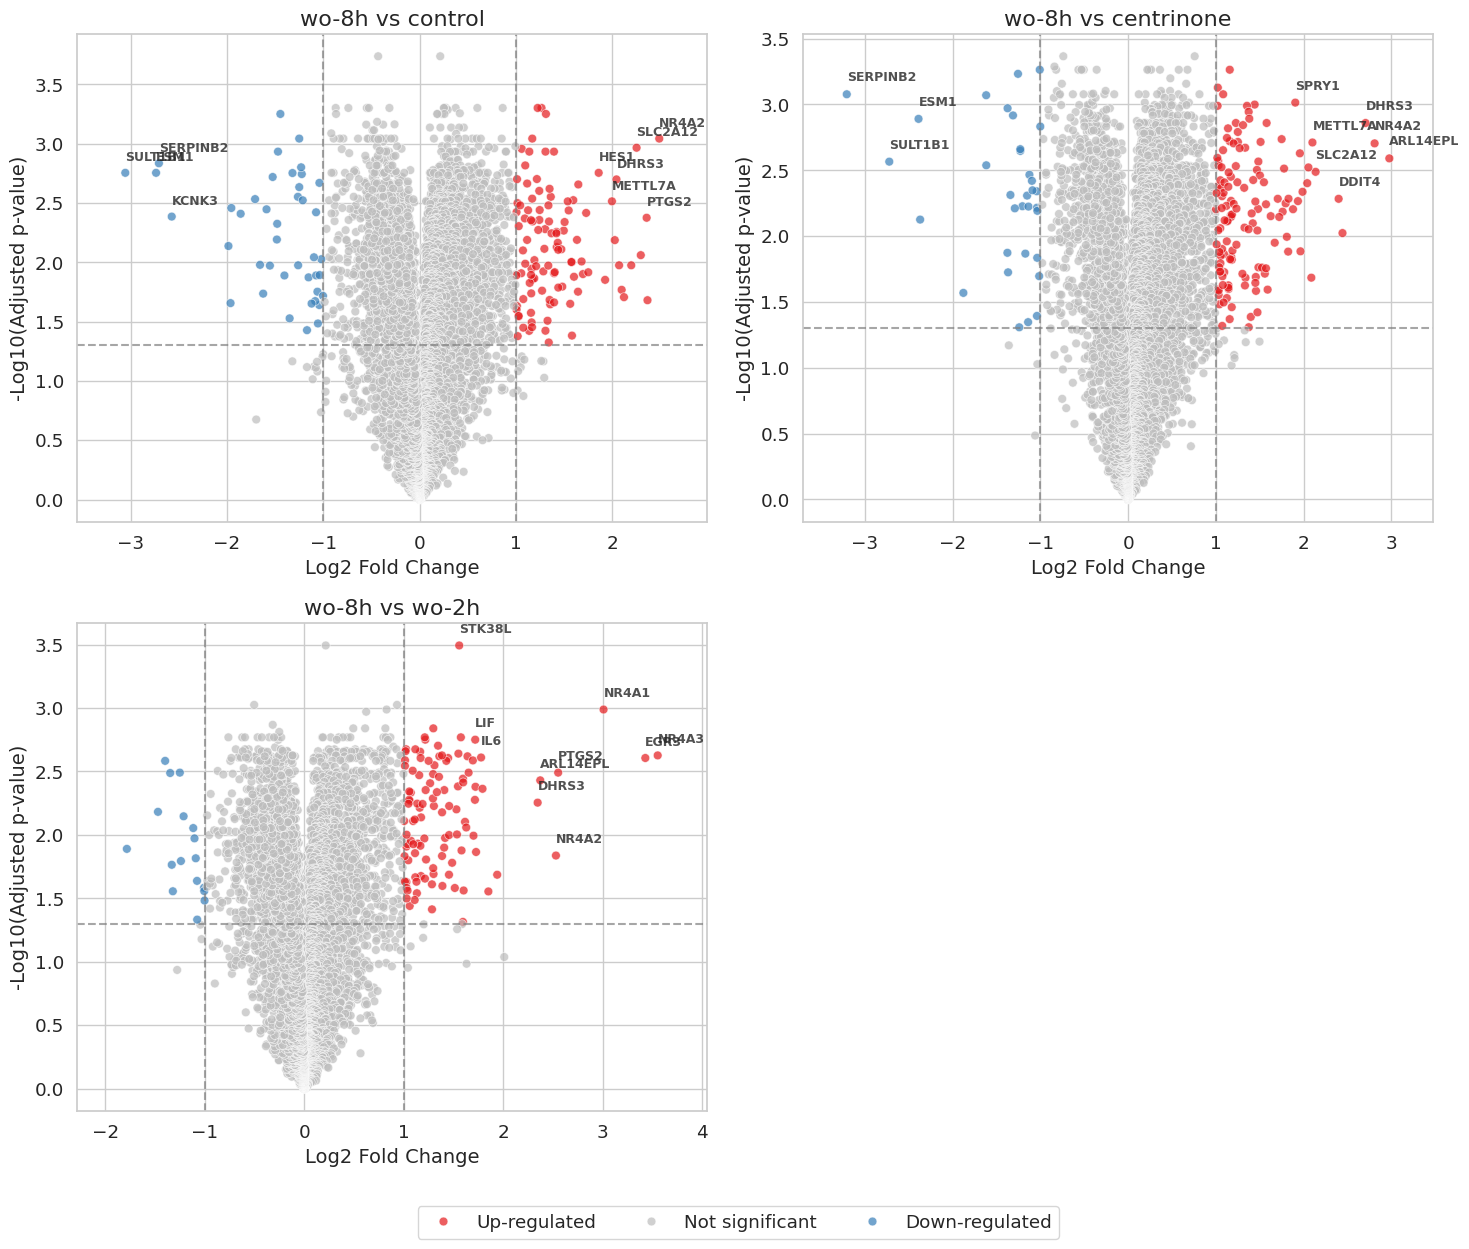

In [14]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='wo-8h',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='wo-8h'  # Specify control condition
)

# Plot
fig = plot_volcano(de_results, control_condition)
# fig.savefig("/home/jiguo/output/pseudobulk_volcano_plots.png", 
            # dpi=300, bbox_inches='tight')
plt.show()

several genes in list A are up-regulated during the recovery of the centrioles, (wash out 2 hours vs wash out 8 hours)
comparing with control and centrinone treatments, some genes in list A are up regulated after centrosome recovery,(wo-8h vs control)
centrosome perturbation with centrinone does not significantly affect the expression of genes in list A(Control vs centrinone)
several genes in list A are also differentialy expressed at the start of the centrosome recovery (wo-2h vs control, wo-2h vs centrinone)

In [15]:
def extract_and_save_regulated_genes(file_path, control_condition, condition, output_dir="/home/jiguo/output/pseudobulk_analysis/genes_list"):
    """
    Extract both up-regulated and down-regulated genes and save as a comprehensive table
    """
    df = pd.read_csv(file_path)
    
    # Filter for the specific comparison
    comparison_data = df[df['comparison'] == f"{control_condition}_vs_{condition}"]
    
    # Up-regulated genes (using pvals_adj for consistency)
    upregulated = comparison_data[
        (comparison_data['pvals_adj'] < 0.05) & 
        (comparison_data['logfoldchanges'] > 1)
    ].copy()
    upregulated['regulation'] = 'Up-regulated'
    
    # Down-regulated genes (using pvals_adj for consistency)
    downregulated = comparison_data[
        (comparison_data['pvals_adj'] < 0.05) & 
        (comparison_data['logfoldchanges'] < -1)
    ].copy()
    downregulated['regulation'] = 'Down-regulated'
    
    # Combine both datasets
    regulated_genes = pd.concat([upregulated, downregulated], ignore_index=True)
    
    if not regulated_genes.empty:
        # Add metadata columns
        regulated_genes['control_condition'] = control_condition
        regulated_genes['comparison_condition'] = condition
        
        # Reorder columns for better readability
        columns_order = [
            'gene_name', 'regulation', 'control_condition', 'comparison_condition',
            'logfoldchanges', 'pvals', 'pvals_adj', 'comparison'
        ]
        # Add any additional columns that might exist
        remaining_cols = [col for col in regulated_genes.columns if col not in columns_order]
        final_columns = columns_order + remaining_cols
        
        regulated_genes = regulated_genes[final_columns]
        
        # Sort by absolute log fold change (descending)
        regulated_genes = regulated_genes.reindex(
            regulated_genes['logfoldchanges'].abs().sort_values(ascending=False).index
        )
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Save comprehensive table
        output_file = f"{output_dir}/regulated_genes_{control_condition}_vs_{condition}.csv"
        regulated_genes.to_csv(output_file, index=False)
        
        # Print summary
        print(f"Regulated genes in {condition} compared to {control_condition}:")
        print(f"Up-regulated: {len(upregulated)} genes")
        print(f"Down-regulated: {len(downregulated)} genes")
        print(f"Total regulated genes: {len(regulated_genes)}")
        print(f"\nResults saved to: {output_file}")
        
        # Print preview of the table
        print(f"\nPreview of regulated genes:")
        print(regulated_genes[['gene_name', 'regulation', 'logfoldchanges', 'pvals_adj']].head(10))
        
        # Also save individual gene lists for compatibility
        upregulated_genes = upregulated['gene_name'].tolist()
        downregulated_genes = downregulated['gene_name'].tolist()
        
        # Save upregulated genes list
        with open(f"{output_dir}/upregulated_genes_{control_condition}_vs_{condition}.txt", 'w') as f:
            for gene in upregulated_genes:
                f.write(f"{gene}\n")
        
        # Save downregulated genes list
        with open(f"{output_dir}/downregulated_genes_{control_condition}_vs_{condition}.txt", 'w') as f:
            for gene in downregulated_genes:
                f.write(f"{gene}\n")
                
        return regulated_genes
        
    else:
        print(f"No significantly regulated genes found for {condition} compared to {control_condition}.")
        return pd.DataFrame()

In [17]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_control.csv",
    control_condition='control', condition='centrinone')

Regulated genes in centrinone compared to control:
Up-regulated: 6 genes
Down-regulated: 11 genes
Total regulated genes: 17

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_control_vs_centrinone.csv

Preview of regulated genes:
   gene_name      regulation  logfoldchanges  pvals_adj
2     SPINK4    Up-regulated        1.446962   0.047224
7      GNGT2  Down-regulated       -1.412851   0.033831
6      ALPK2  Down-regulated       -1.356161   0.032014
8     DIRAS1  Down-regulated       -1.265655   0.012023
13    MT-ND2  Down-regulated       -1.190226   0.007285
15    MT-ND1  Down-regulated       -1.134261   0.005038
14   MT-ND4L  Down-regulated       -1.128911   0.000168
0    PLEKHB1    Up-regulated        1.124615   0.035587
1     CHI3L2    Up-regulated        1.118186   0.026282
16   MT-ATP6  Down-regulated       -1.066363   0.000009


gene_name      regulation control_condition comparison_condition  \
2     SPINK4    Up-regulated           control           centrinone   
7      GNGT2  Down-regulated           control           centrinone   
6      ALPK2  Down-regulated           control           centrinone   
8     DIRAS1  Down-regulated           control           centrinone   
13    MT-ND2  Down-regulated           control           centrinone   
15    MT-ND1  Down-regulated           control           centrinone   
14   MT-ND4L  Down-regulated           control           centrinone   
0    PLEKHB1    Up-regulated           control           centrinone   
1     CHI3L2    Up-regulated           control           centrinone   
16   MT-ATP6  Down-regulated           control           centrinone   
10    MT-ND6  Down-regulated           control           centrinone   
5      RAB7B    Up-regulated           control           centrinone   
4    AKR1B10    Up-regulated           control           centrinone   
9       EGR3  Down-regulated           control           centrinone   
12    MT-CO2  Down-regulated           control           centrinone   
11    MT-CO3  Down-regulated           control           centrinone   
3     SNRPD3    Up-regulated           control           centrinone   

    logfoldchanges         pvals  pvals_adj             comparison    names  \
2         1.446962  6.115813e-03   0.047224  control_vs_centrinone   SPINK4   
7        -1.412851  2.427282e-03   0.033831  control_vs_centrinone    GNGT2   
6        -1.356161  2.018455e-03   0.032014  control_vs_centrinone    ALPK2   
8        -1.265655  7.428944e-05   0.012023  control_vs_centrinone   DIRAS1   
13       -1.190226  1.147400e-05   0.007285  control_vs_centrinone   MT-ND2   
15       -1.134261  3.960981e-06   0.005038  control_vs_centrinone   MT-ND1   
14       -1.128911  4.403907e-08   0.000168  control_vs_centrinone  MT-ND4L   
0         1.124615  2.780171e-03   0.035587  control_vs_centrinone  PLEKHB1   
1         1.118186  1.073713e-03   0.026282  control_vs_centrinone   CHI3L2   
16       -1.066363  7.632791e-10   0.000009  control_vs_centrinone  MT-ATP6   
10       -1.063969  4.053137e-06   0.005038  control_vs_centrinone   MT-ND6   
5         1.057067  5.258327e-03   0.044283  control_vs_centrinone    RAB7B   
4         1.055188  1.983482e-03   0.031838  control_vs_centrinone  AKR1B10   
9        -1.052431  5.640027e-06   0.005371  control_vs_centrinone     EGR3   
12       -1.030081  9.042626e-05   0.012517  control_vs_centrinone   MT-CO2   
11       -1.024207  7.098415e-05   0.012023  control_vs_centrinone   MT-CO3   
3         1.008165  1.388666e-03   0.028389  control_vs_centrinone   SNRPD3   

        scores  -log10_pvals_adj  control   treatment  
2     8.036318          1.325837  control  centrinone  
7   -12.933166          1.470688  control  centrinone  
6   -12.886802          1.494661  control  centrinone  
8   -18.928764          1.919985  control  centrinone  
13  -90.589740          2.137588  control  centrinone  
15 -124.299290          2.297730  control  centrinone  
14 -114.582664          3.775313  control  centrinone  
0    13.785595          1.448708  control  centrinone  
1    10.747638          1.580341  control  centrinone  
16 -319.118740          5.059346  control  centrinone  
10  -60.171795          2.297730  control  centrinone  
5     6.149927          1.353762  control  centrinone  
4     7.497562          1.497055  control  centrinone  
9   -34.308887          2.269930  control  centrinone  
12  -81.783910          1.902494  control  centrinone  
11  -78.621980          1.919985  control  centrinone  
3     7.922458          1.546844  control  centrinone

In [18]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_control.csv",
    control_condition='control', condition='wo-2h')

Regulated genes in wo-2h compared to control:
Up-regulated: 119 genes
Down-regulated: 61 genes
Total regulated genes: 180

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_control_vs_wo-2h.csv

Preview of regulated genes:
    gene_name      regulation  logfoldchanges  pvals_adj
79      CXCL8    Up-regulated        3.752601   0.010466
73     NFATC2    Up-regulated        3.419447   0.007152
56      BIRC3    Up-regulated        3.266027   0.011946
41      NR4A3    Up-regulated        2.974219   0.006008
51    TNFAIP3    Up-regulated        2.960019   0.007950
75       RELB    Up-regulated        2.877109   0.015282
70   KRTAP2-3    Up-regulated        2.575277   0.003410
44      CXCL3    Up-regulated        2.536562   0.003265
48   SERPINB2    Up-regulated        2.534090   0.001902
159     MELTF  Down-regulated       -2.527433   0.013468


gene_name      regulation control_condition comparison_condition  \
79      CXCL8    Up-regulated           control                wo-2h   
73     NFATC2    Up-regulated           control                wo-2h   
56      BIRC3    Up-regulated           control                wo-2h   
41      NR4A3    Up-regulated           control                wo-2h   
51    TNFAIP3    Up-regulated           control                wo-2h   
..        ...             ...               ...                  ...   
64       MAFF    Up-regulated           control                wo-2h   
95    PLA2G4A    Up-regulated           control                wo-2h   
142      TET1  Down-regulated           control                wo-2h   
151     EVA1C  Down-regulated           control                wo-2h   
38     ZNF641    Up-regulated           control                wo-2h   

     logfoldchanges     pvals  pvals_adj        comparison    names  \
79         3.752601  0.001601   0.010466  control_vs_wo-2h    CXCL8   
73         3.419447  0.000721   0.007152  control_vs_wo-2h   NFATC2   
56         3.266027  0.002081   0.011946  control_vs_wo-2h    BIRC3   
41         2.974219  0.000472   0.006008  control_vs_wo-2h    NR4A3   
51         2.960019  0.000929   0.007950  control_vs_wo-2h  TNFAIP3   
..              ...       ...        ...               ...      ...   
64         1.007613  0.000151   0.003674  control_vs_wo-2h     MAFF   
95         1.005369  0.002576   0.013342  control_vs_wo-2h  PLA2G4A   
142       -1.004419  0.003371   0.015342  control_vs_wo-2h     TET1   
151       -1.003765  0.000383   0.005405  control_vs_wo-2h    EVA1C   
38         1.002980  0.000028   0.001973  control_vs_wo-2h   ZNF641   

        scores  -log10_pvals_adj  control treatment  
79   14.963238          1.980225  control     wo-2h  
73   15.703323          2.145595  control     wo-2h  
56   21.652174          1.922762  control     wo-2h  
41   25.902536          2.221299  control     wo-2h  
51   22.741663          2.099618  control     wo-2h  
..         ...               ...      ...       ...  
64   17.893661          2.434908  control     wo-2h  
95   10.068391          1.874787  control     wo-2h  
142  -9.263891          1.814118  control     wo-2h  
151 -12.049207          2.267165  control     wo-2h  
38   27.399200          2.704791  control     wo-2h  

[180 rows x 13 columns]

In [19]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_control.csv",
    control_condition='control', condition='wo-8h')

Regulated genes in wo-8h compared to control:
Up-regulated: 42 genes
Down-regulated: 106 genes
Total regulated genes: 148

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_control_vs_wo-8h.csv

Preview of regulated genes:
    gene_name      regulation  logfoldchanges  pvals_adj
9     SULT1B1    Up-regulated        3.054121   0.001757
11       ESM1    Up-regulated        2.734698   0.001757
7    SERPINB2    Up-regulated        2.705241   0.001460
19      KCNK3    Up-regulated        2.572171   0.004111
137     NR4A2  Down-regulated       -2.488326   0.000904
90       ATF3  Down-regulated       -2.366150   0.020848
117     PTGS2  Down-regulated       -2.357321   0.004206
78   ARL14EPL  Down-regulated       -2.296652   0.008692
139   SLC2A12  Down-regulated       -2.252896   0.001080
110      EGR3  Down-regulated       -2.197551   0.010583


gene_name      regulation control_condition comparison_condition  \
9     SULT1B1    Up-regulated           control                wo-8h   
11       ESM1    Up-regulated           control                wo-8h   
7    SERPINB2    Up-regulated           control                wo-8h   
19      KCNK3    Up-regulated           control                wo-8h   
137     NR4A2  Down-regulated           control                wo-8h   
..        ...             ...               ...                  ...   
51      SH2B2  Down-regulated           control                wo-8h   
48    SLC6A16  Down-regulated           control                wo-8h   
108     STON1  Down-regulated           control                wo-8h   
79    FAM117B  Down-regulated           control                wo-8h   
35      CREB5    Up-regulated           control                wo-8h   

     logfoldchanges     pvals  pvals_adj        comparison     names  \
9          3.054121  0.000033   0.001757  control_vs_wo-8h   SULT1B1   
11         2.734698  0.000029   0.001757  control_vs_wo-8h      ESM1   
7          2.705241  0.000016   0.001460  control_vs_wo-8h  SERPINB2   
19         2.572171  0.000295   0.004111  control_vs_wo-8h     KCNK3   
137       -2.488326  0.000005   0.000904  control_vs_wo-8h     NR4A2   
..              ...       ...        ...               ...       ...   
51        -1.011337  0.007852   0.023387  control_vs_wo-8h     SH2B2   
48        -1.007264  0.008695   0.025024  control_vs_wo-8h   SLC6A16   
108       -1.006709  0.000241   0.003772  control_vs_wo-8h     STON1   
79        -1.006100  0.002887   0.012858  control_vs_wo-8h   FAM117B   
35         1.001628  0.005645   0.019177  control_vs_wo-8h     CREB5   

        scores  -log10_pvals_adj  control treatment  
9    25.166632          2.755157  control     wo-8h  
11   24.641062          2.755157  control     wo-8h  
7    28.383280          2.835615  control     wo-8h  
19   15.608109          2.386079  control     wo-8h  
137 -37.326042          3.043845  control     wo-8h  
..         ...               ...      ...       ...  
51   -6.580043          1.631027  control     wo-8h  
48   -5.594480          1.601637  control     wo-8h  
108 -17.711502          2.423416  control     wo-8h  
79  -10.047389          1.890841  control     wo-8h  
35    7.280671          1.717220  control     wo-8h  

[148 rows x 13 columns]

In [20]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv",
    control_condition='centrinone', condition='wo-2h')

Regulated genes in wo-2h compared to centrinone:
Up-regulated: 93 genes
Down-regulated: 61 genes
Total regulated genes: 154

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_centrinone_vs_wo-2h.csv

Preview of regulated genes:
    gene_name      regulation  logfoldchanges  pvals_adj
72   KRTAP2-3    Up-regulated        3.332597   0.009342
33   SERPINB2    Up-regulated        3.035613   0.001877
71     NFATC2    Up-regulated        2.868771   0.014572
86      CXCL8    Up-regulated        2.825647   0.024526
45    TNFAIP3    Up-regulated        2.698120   0.006052
79      PAQR9    Up-regulated        2.696648   0.008431
9        CSF2    Up-regulated        2.688765   0.001437
41       EGR3    Up-regulated        2.282890   0.007794
40      BIRC3    Up-regulated        2.262369   0.009852
120     DDIT4  Down-regulated       -2.244150   0.011314


gene_name      regulation control_condition comparison_condition  \
72   KRTAP2-3    Up-regulated        centrinone                wo-2h   
33   SERPINB2    Up-regulated        centrinone                wo-2h   
71     NFATC2    Up-regulated        centrinone                wo-2h   
86      CXCL8    Up-regulated        centrinone                wo-2h   
45    TNFAIP3    Up-regulated        centrinone                wo-2h   
..        ...             ...               ...                  ...   
103  ANKRD33B  Down-regulated        centrinone                wo-2h   
110    CCDC17  Down-regulated        centrinone                wo-2h   
81       PER2    Up-regulated        centrinone                wo-2h   
31      ARAP2    Up-regulated        centrinone                wo-2h   
8         SRF    Up-regulated        centrinone                wo-2h   

     logfoldchanges     pvals  pvals_adj           comparison     names  \
72         3.332597  0.001009   0.009342  centrinone_vs_wo-2h  KRTAP2-3   
33         3.035613  0.000016   0.001877  centrinone_vs_wo-2h  SERPINB2   
71         2.868771  0.002486   0.014572  centrinone_vs_wo-2h    NFATC2   
86         2.825647  0.006618   0.024526  centrinone_vs_wo-2h     CXCL8   
45         2.698120  0.000352   0.006052  centrinone_vs_wo-2h   TNFAIP3   
..              ...       ...        ...                  ...       ...   
103       -1.013389  0.013700   0.037618  centrinone_vs_wo-2h  ANKRD33B   
110       -1.011814  0.013102   0.036638  centrinone_vs_wo-2h    CCDC17   
81         1.007847  0.000717   0.008015  centrinone_vs_wo-2h      PER2   
31         1.004720  0.000005   0.001184  centrinone_vs_wo-2h     ARAP2   
8          1.001578  0.000179   0.004670  centrinone_vs_wo-2h       SRF   

        scores  -log10_pvals_adj     control treatment  
72   14.333385          2.029546  centrinone     wo-2h  
33   31.715958          2.726571  centrinone     wo-2h  
71   14.636461          1.836493  centrinone     wo-2h  
86    9.354016          1.610379  centrinone     wo-2h  
45   27.117077          2.218093  centrinone     wo-2h  
..         ...               ...         ...       ...  
103  -6.897988          1.424607  centrinone     wo-2h  
110  -7.974432          1.436068  centrinone     wo-2h  
81   11.792041          2.096099  centrinone     wo-2h  
31   33.589750          2.926507  centrinone     wo-2h  
8    49.200977          2.330697  centrinone     wo-2h  

[154 rows x 13 columns]

In [21]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv",
    control_condition='centrinone', condition='wo-8h')

Regulated genes in wo-8h compared to centrinone:
Up-regulated: 33 genes
Down-regulated: 136 genes
Total regulated genes: 169

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_centrinone_vs_wo-8h.csv

Preview of regulated genes:
    gene_name      regulation  logfoldchanges  pvals_adj
5    SERPINB2    Up-regulated        3.206764   0.000837
140  ARL14EPL  Down-regulated       -2.976899   0.002569
164     NR4A2  Down-regulated       -2.808962   0.001976
6     SULT1B1    Up-regulated        2.722348   0.002719
163     DHRS3  Down-regulated       -2.706023   0.001383
116    PPFIA4  Down-regulated       -2.442957   0.009478
89      DDIT4  Down-regulated       -2.398963   0.005207
10       ESM1    Up-regulated        2.388959   0.001287
11      KCNK3    Up-regulated        2.370535   0.007488
161   SLC2A12  Down-regulated       -2.136587   0.003249


gene_name      regulation control_condition comparison_condition  \
5    SERPINB2    Up-regulated        centrinone                wo-8h   
140  ARL14EPL  Down-regulated        centrinone                wo-8h   
164     NR4A2  Down-regulated        centrinone                wo-8h   
6     SULT1B1    Up-regulated        centrinone                wo-8h   
163     DHRS3  Down-regulated        centrinone                wo-8h   
..        ...             ...               ...                  ...   
49      YPEL2  Down-regulated        centrinone                wo-8h   
80      SPAG4  Down-regulated        centrinone                wo-8h   
1     TMEM158    Up-regulated        centrinone                wo-8h   
114       AK4  Down-regulated        centrinone                wo-8h   
13      GREM1    Up-regulated        centrinone                wo-8h   

     logfoldchanges         pvals  pvals_adj           comparison     names  \
5          3.206764  2.405209e-06   0.000837  centrinone_vs_wo-8h  SERPINB2   
140       -2.976899  1.038374e-04   0.002569  centrinone_vs_wo-8h  ARL14EPL   
164       -2.808962  5.490932e-05   0.001976  centrinone_vs_wo-8h     NR4A2   
6          2.722348  1.149367e-04   0.002719  centrinone_vs_wo-8h   SULT1B1   
163       -2.706023  1.792096e-05   0.001383  centrinone_vs_wo-8h     DHRS3   
..              ...           ...        ...                  ...       ...   
49        -1.008367  2.685264e-03   0.011550  centrinone_vs_wo-8h     YPEL2   
80        -1.007856  4.658780e-04   0.004712  centrinone_vs_wo-8h     SPAG4   
1          1.007204  3.824755e-07   0.000545  centrinone_vs_wo-8h   TMEM158   
114       -1.001699  8.459650e-04   0.006247  centrinone_vs_wo-8h       AK4   
13         1.001120  2.201416e-05   0.001472  centrinone_vs_wo-8h     GREM1   

        scores  -log10_pvals_adj     control treatment  
5    40.010376          3.077230  centrinone     wo-8h  
140 -25.053207          2.590318  centrinone     wo-8h  
164 -50.604694          2.704236  centrinone     wo-8h  
6    36.755450          2.565518  centrinone     wo-8h  
163 -49.580254          2.859154  centrinone     wo-8h  
..         ...               ...         ...       ...  
49   -6.630386          1.937434  centrinone     wo-8h  
80  -10.836271          2.326771  centrinone     wo-8h  
1    83.380104          3.263492  centrinone     wo-8h  
114 -17.331253          2.204319  centrinone     wo-8h  
13   25.086422          2.832236  centrinone     wo-8h  

[169 rows x 13 columns]

In [22]:
extract_and_save_regulated_genes(
    "/home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv",
    control_condition='wo-2h', condition='wo-8h')

Regulated genes in wo-8h compared to wo-2h:
Up-regulated: 17 genes
Down-regulated: 109 genes
Total regulated genes: 126

Results saved to: /home/jiguo/output/pseudobulk_analysis/genes_list/regulated_genes_wo-2h_vs_wo-8h.csv

Preview of regulated genes:
    gene_name      regulation  logfoldchanges  pvals_adj
95      NR4A3  Down-regulated       -3.552366   0.002363
99       EGR3  Down-regulated       -3.428010   0.002477
123     NR4A1  Down-regulated       -3.008000   0.001028
73      PTGS2  Down-regulated       -2.551634   0.003230
60      NR4A2  Down-regulated       -2.529266   0.014544
69   ARL14EPL  Down-regulated       -2.371579   0.003716
120     DHRS3  Down-regulated       -2.345384   0.005569
48     NFATC2  Down-regulated       -1.938634   0.020602
45       CSF2  Down-regulated       -1.849991   0.027904
61      CXCL8  Down-regulated       -1.790932   0.004332


gene_name      regulation control_condition comparison_condition  \
95      NR4A3  Down-regulated             wo-2h                wo-8h   
99       EGR3  Down-regulated             wo-2h                wo-8h   
123     NR4A1  Down-regulated             wo-2h                wo-8h   
73      PTGS2  Down-regulated             wo-2h                wo-8h   
60      NR4A2  Down-regulated             wo-2h                wo-8h   
..        ...             ...               ...                  ...   
14     RHEBL1    Up-regulated             wo-2h                wo-8h   
10      GFRA1    Up-regulated             wo-2h                wo-8h   
64      NUAK2  Down-regulated             wo-2h                wo-8h   
94       IL11  Down-regulated             wo-2h                wo-8h   
16      RAPSN    Up-regulated             wo-2h                wo-8h   

     logfoldchanges         pvals  pvals_adj      comparison   names  \
95        -3.552366  2.240535e-05   0.002363  wo-2h_vs_wo-8h   NR4A3   
99        -3.428010  3.575320e-05   0.002477  wo-2h_vs_wo-8h    EGR3   
123       -3.008000  5.394962e-07   0.001028  wo-2h_vs_wo-8h   NR4A1   
73        -2.551634  7.239546e-05   0.003230  wo-2h_vs_wo-8h   PTGS2   
60        -2.529266  2.585994e-03   0.014544  wo-2h_vs_wo-8h   NR4A2   
..              ...           ...        ...             ...     ...   
14         1.008922  7.636127e-03   0.026084  wo-2h_vs_wo-8h  RHEBL1   
10         1.007134  8.460679e-03   0.027712  wo-2h_vs_wo-8h   GFRA1   
64        -1.006900  2.656919e-03   0.014718  wo-2h_vs_wo-8h   NUAK2   
94        -1.003712  6.648880e-04   0.007767  wo-2h_vs_wo-8h    IL11   
16         1.003573  1.126204e-02   0.032910  wo-2h_vs_wo-8h   RAPSN   

        scores  -log10_pvals_adj control treatment  
95  -23.726490          2.626467   wo-2h     wo-8h  
99  -24.500866          2.606126   wo-2h     wo-8h  
123 -64.773270          2.988193   wo-2h     wo-8h  
73  -16.882051          2.490765   wo-2h     wo-8h  
60  -13.916426          1.837326   wo-2h     wo-8h  
..         ...               ...     ...       ...  
14    4.995431          1.583619   wo-2h     wo-8h  
10    6.551916          1.557326   wo-2h     wo-8h  
64  -14.207171          1.832151   wo-2h     wo-8h  
94  -23.013945          2.109739   wo-2h     wo-8h  
16    4.525156          1.482670   wo-2h     wo-8h  

[126 rows x 13 columns]

### Significantly regulated genes comparing with **Control condition**

In [35]:
input_csv = "/home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv"
output_rnk = "/home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.rnk"
# Read your differential expression results from the CSV file
df = pd.read_csv(input_csv)
# Select the 'gene_name' and 'scores' columns
# The 'scores' column is a good choice for a ranking metric.
ranked_df = df[['gene_name', 'scores']].copy()
# Sort the dataframe by the 'scores' column in descending order
ranked_df = ranked_df.sort_values(by='scores', ascending=False)
# Save the ranked list to a .rnk file
# The output will be a tab-separated file with no header or index.
ranked_df.to_csv(output_rnk, sep="\t", header=False, index=False)
print(f"Successfully created the .rnk file at: {output_rnk}")

Successfully created the .rnk file at: /home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.rnk


### GSEA analysis

### Plot a heatmap for visualizing the expression pattern

In [67]:
# heatmap for the Expression pattern of the genes from list C
# load list C
gene_list = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/gene_with_GO_terms_related_with_CentrosomeBiosynthesis.txt")['gene_names'].tolist()
# create a gene mask and apply to the pseudobulk_adata
gene_mask = pseudobulk_adata.var_names.isin(gene_list)
c_adata = pseudobulk_adata[:, gene_mask].copy()
c_adata

AnnData object with n_obs × n_vars = 12 × 23
    obs: 'condition', 'replicate'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'rank_genes_groups'

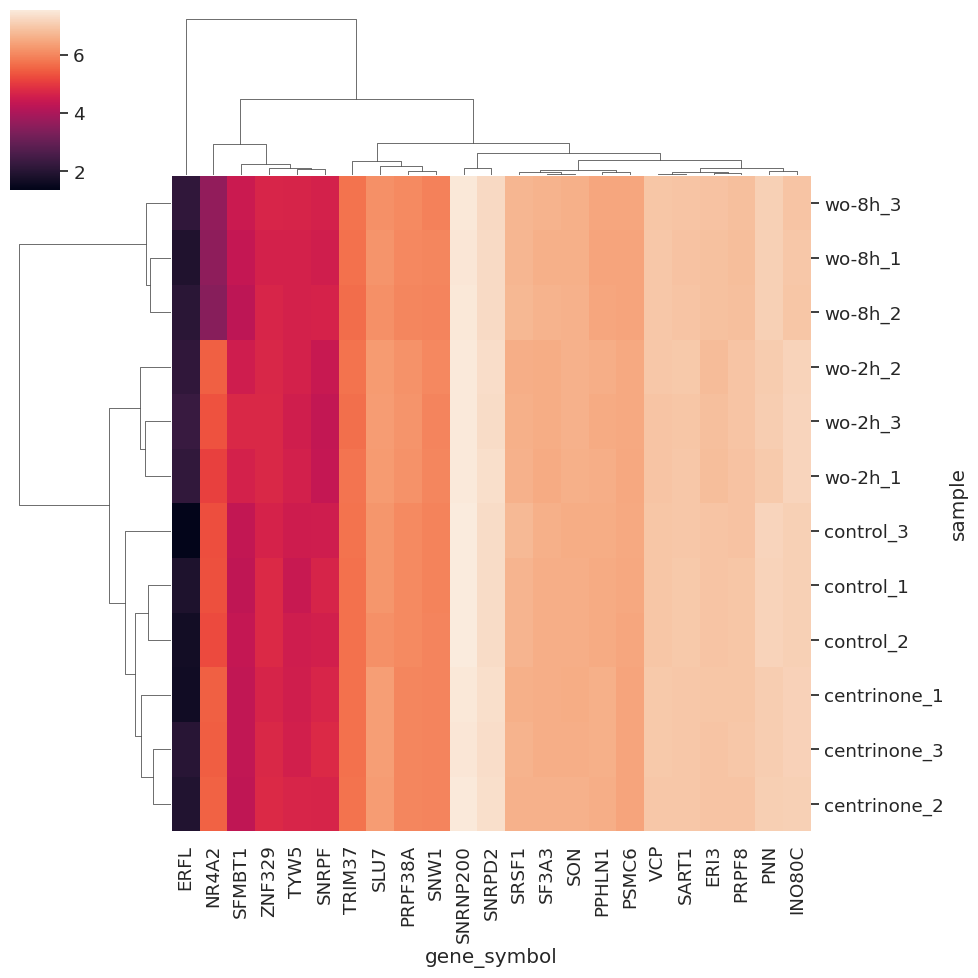

In [68]:
# plot a heatmap based on for the genes in list C
# Convert .X to dense (if sparse)
if sparse.issparse(c_adata.X):
    c_adata.X = c_adata.X.toarray()
sc.pl.clustermap(
    c_adata,
    use_raw=False,
    show=True
)

In [69]:
pseudobulk_adata

AnnData object with n_obs × n_vars = 12 × 1314
    obs: 'condition', 'replicate'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'rank_genes_groups'

/home/jiguo/denovo_rpe1_scrnaseq/venvs/rna/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jiguo/denovo_rpe1_scrnaseq/venvs/rna/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


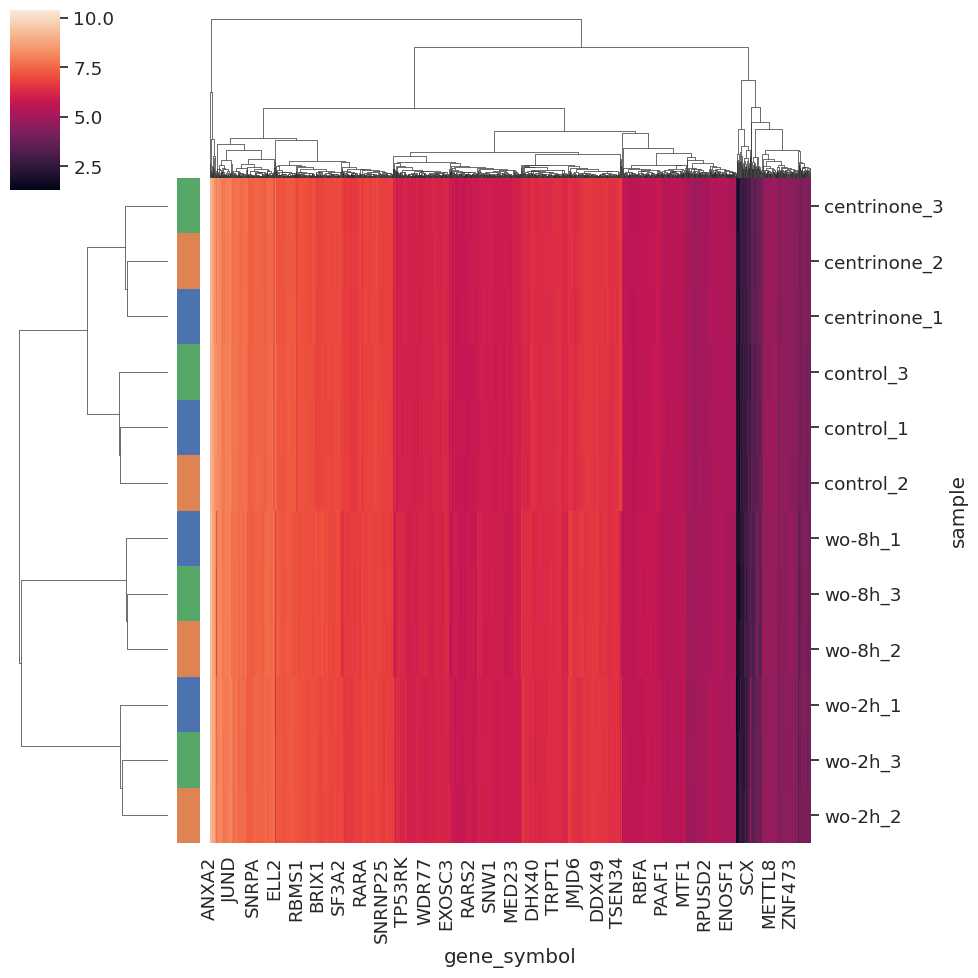

In [70]:
if sparse.issparse(pseudobulk_adata.X):
    pseudobulk_adata.X = pseudobulk_adata.X.toarray()
# 
sc.pl.clustermap(
    pseudobulk_adata,
    use_raw=False,
    show=False,
    obs_keys = 'replicate',
)

In [73]:
def plot_specila_volcano(de_results, control_condition):
    # Get conditions from de_results keys, not adata.obs
    conditions = list(de_results.keys())
    n_conditions = len(conditions)
    mRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/mRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    rRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/rRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    tRNA_genes = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/tRNA_processing.txt",delimiter='\t')['Gene_name'].tolist()
    # Calculate grid dimensions
    n_cols = min(2, n_conditions)
    n_rows = (n_conditions + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 6*n_rows))
    sns.set(style='whitegrid', font_scale=1.2)
    
    for i, cond in enumerate(conditions, 1):
        df = de_results[cond]
        ax = plt.subplot(n_rows, n_cols, i)  # Fixed index: use i not i+1
        
        # Significance thresholds (use pvals_adj for FDR)
        sig_threshold = 0.05
        logfc_threshold = 1
        
        df['significance'] = 'Not significant'
        
        # Highlight mRNA processing genes
        df['is_mRNA'] = df['gene_name'].isin(mRNA_genes)
        df['is_rRNA'] = df['gene_name'].isin(rRNA_genes)
        df['is_tRNA'] = df['gene_name'].isin(tRNA_genes)
        df['significance'] = np.where(df['is_rRNA'], 'rRNA processing', df['significance'])
        df['significance'] = np.where(df['is_tRNA'], 'tRNA processing', df['significance'])
        df['significance'] = np.where(df['is_mRNA'], 'mRNA processing', df['significance'])
        df['significance'] = pd.Categorical(df['significance'], 
                                            categories=['mRNA processing', 'rRNA processing', 'tRNA processing','Not significant'],)
        # Use a consistent color palette
        sns.scatterplot(
            data=df,
            x='logfoldchanges',
            y='-log10_pvals_adj',  # Match the column name
            hue='significance',
            palette={
                'mRNA processing': '#ff7f00',  # Orange for mRNA processing genes
                'rRNA processing': '#4daf4a',  # Green for rRNA processing genes
                'tRNA processing': '#ff00ff',  # Magenta for tRNA processing genes
                'Not significant': '#bdbdbd'  # Gray for non-significant genes
            },
            alpha=0.7,
            s=40,
            ax=ax
        )
        # Gene labeling - better approach
        df['combined_score'] = np.abs(df['logfoldchanges']) * df['-log10_pvals_adj']
        top_genes = df.nlargest(10, 'combined_score')

        for _, row in top_genes.iterrows():
            ax.text(
                row['logfoldchanges'],
                row['-log10_pvals_adj'] + 0.1,  # Offset to avoid overlap
                row['gene_name'],
                fontsize=9,
                alpha=0.8,
                fontweight='bold'
            )
        # Add thresholdsa
        ax.axhline(-np.log10(sig_threshold), color='gray', linestyle='--', alpha=0.7)
        ax.axvline(logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        ax.axvline(-logfc_threshold, color='gray', linestyle='--', alpha=0.7)
        # Correct title
        ax.set_title(f'{control_condition} vs {cond}', fontsize=16)  # Fixed title
        ax.set_xlabel('Log2 Fold Change', fontsize=14)
        ax.set_ylabel('-Log10(Adjusted p-value)', fontsize=14)
        ax.set_xlim(df['logfoldchanges'].min()-0.5, df['logfoldchanges'].max()+0.5)
        ax.legend().remove()  # Remove individual legends
    
    # Add common legend
    plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=3)

    
    return plt

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_control.csv with condition information


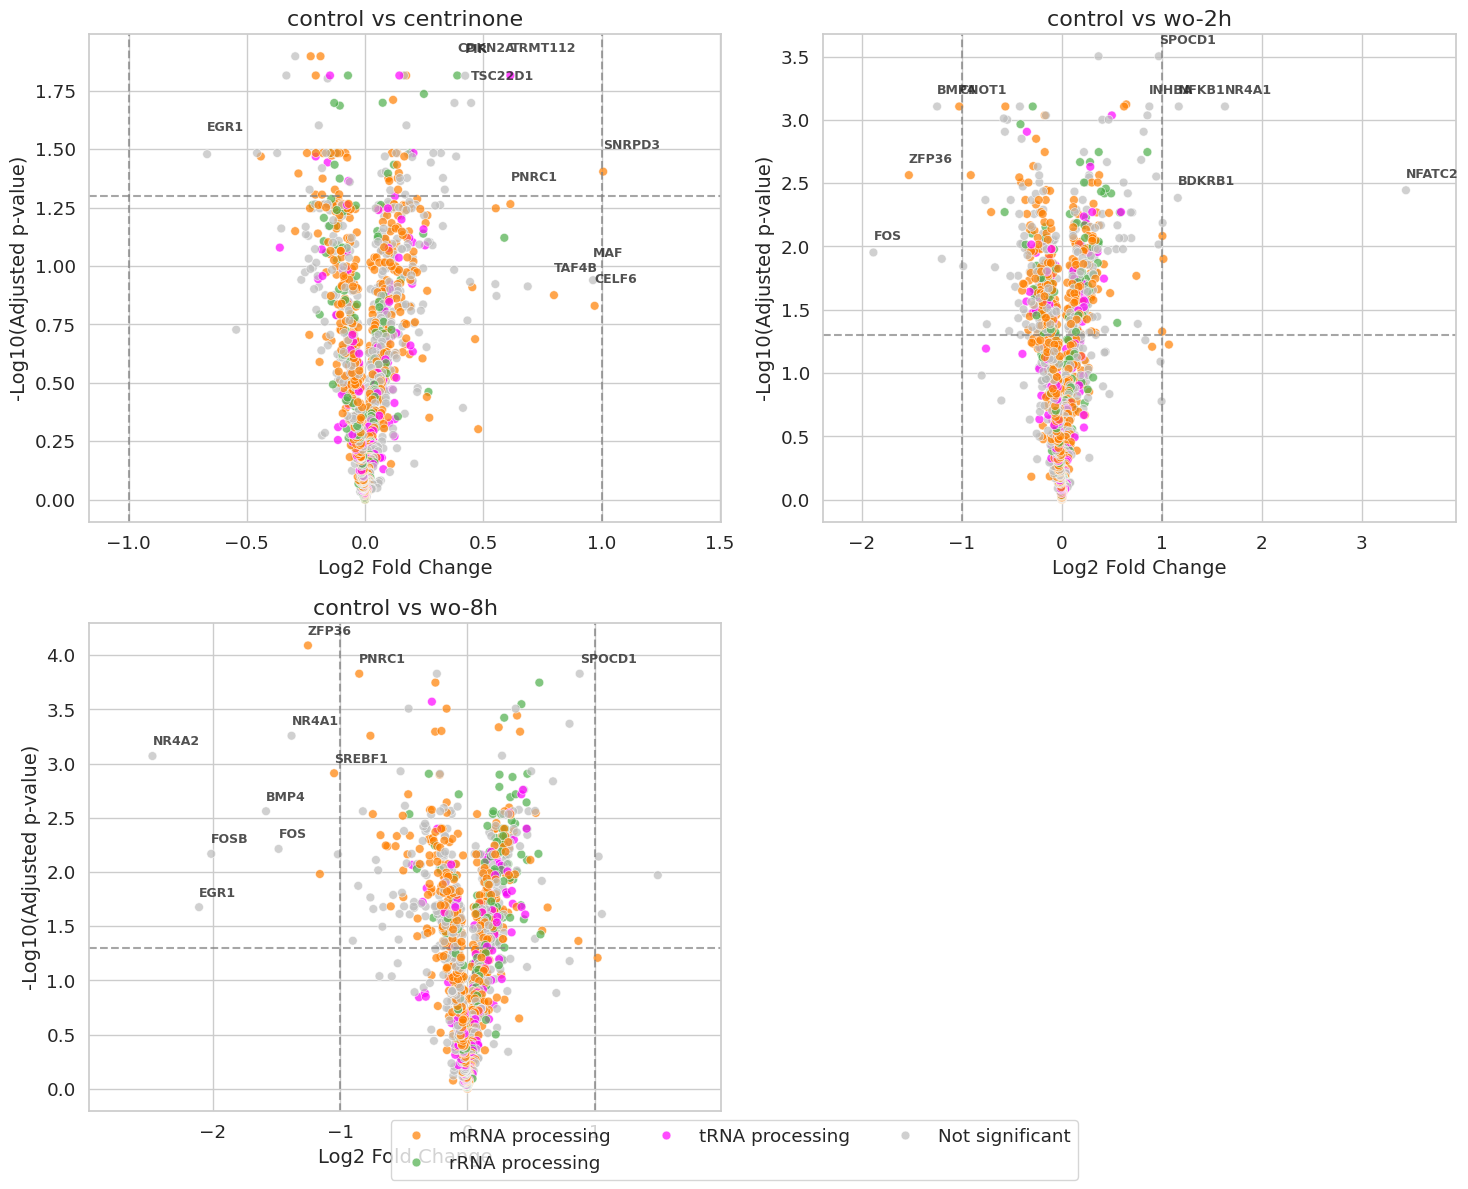

In [74]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='control',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='control'  # Specify control condition
)

# Plot
fig = plot_specila_volcano(de_results, control_condition)
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_centrinone.csv with condition information


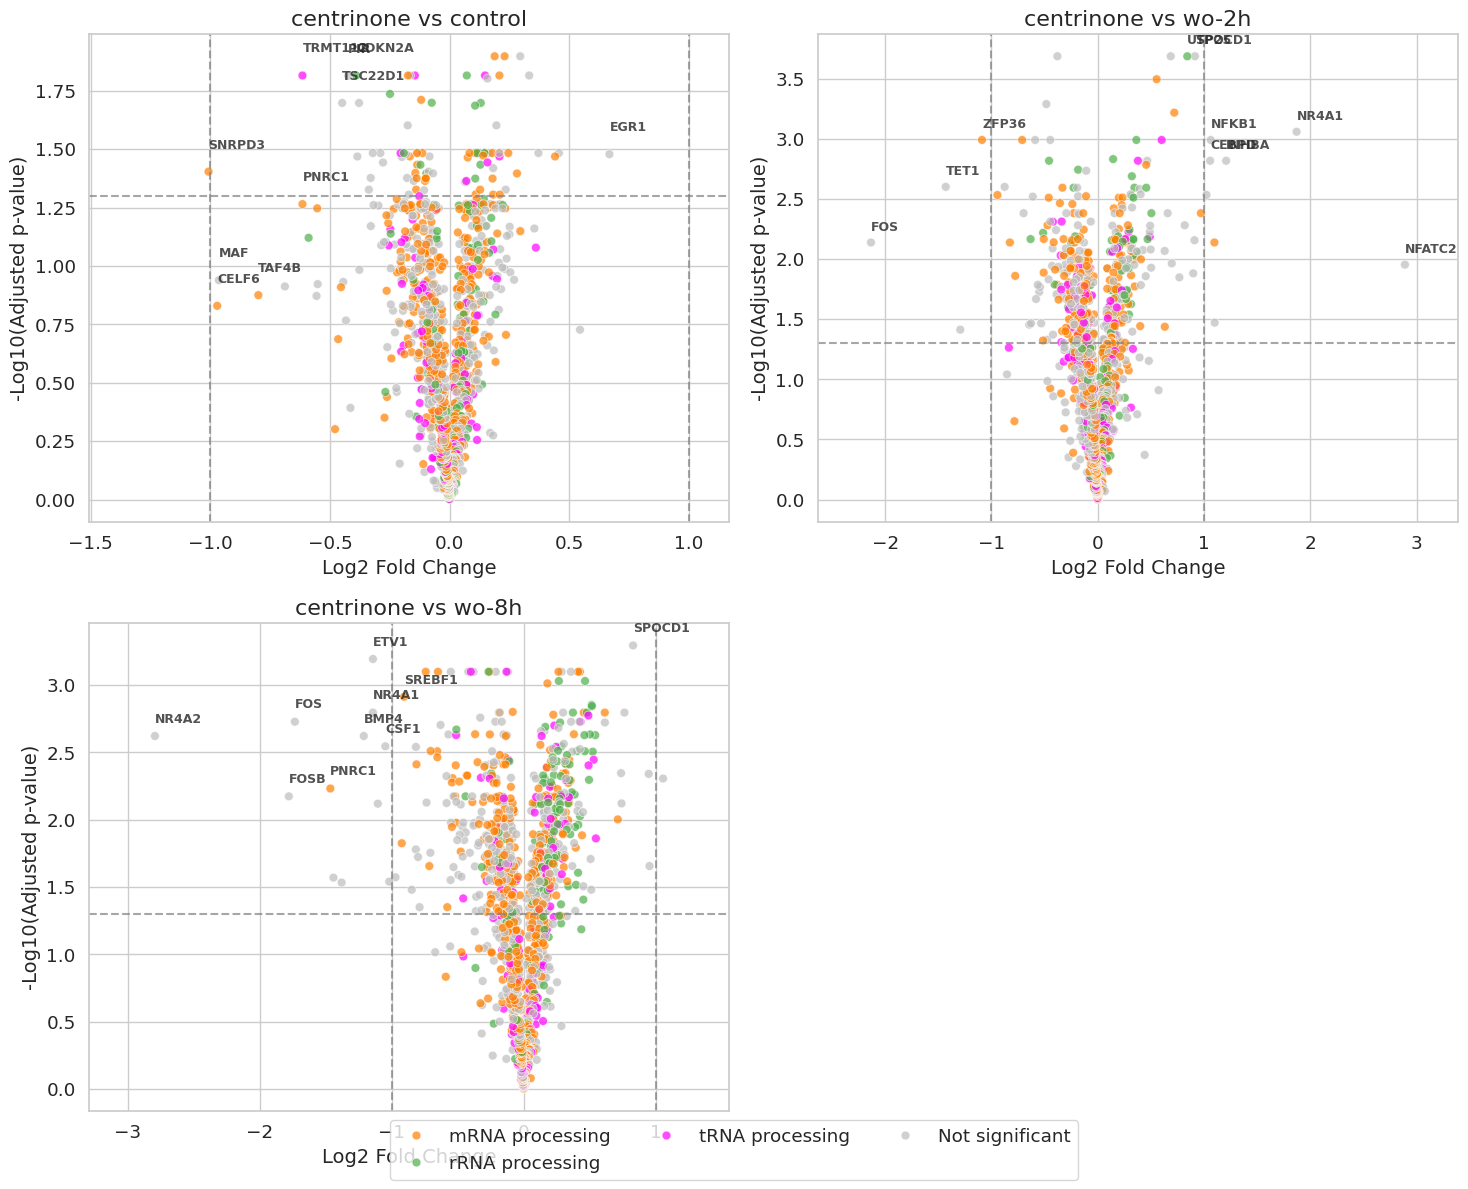

In [75]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='centrinone',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='centrinone'  # Specify control condition
)

# Plot
fig = plot_specila_volcano(de_results, control_condition)
plt.show()

DE results saved to /home/jiguo/output/pseudobulk_analysis/de_results_wo-2h.csv with condition information


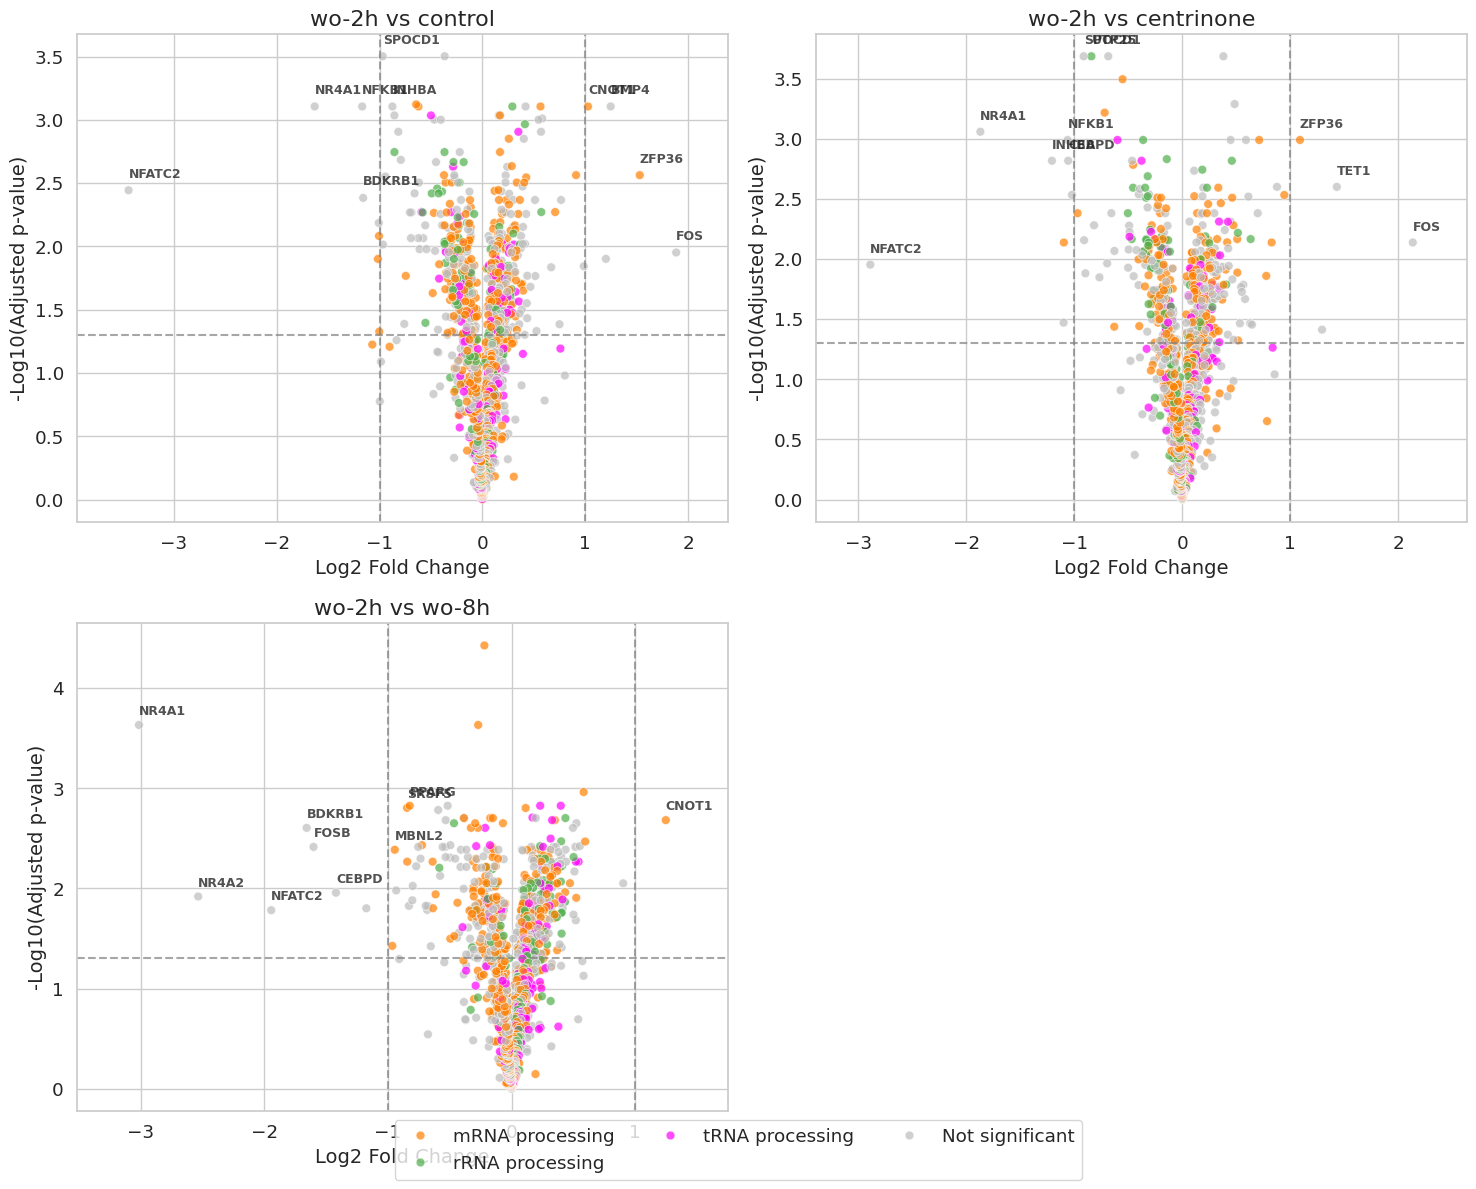

In [76]:
# First run DE analysis
sc.tl.rank_genes_groups(
    pseudobulk_adata,
    groupby='condition',
    reference='wo-2h',  # Set control as reference
    method='t-test_overestim_var'
)
# Extract results
de_results, control_condition = extract_de_results(
    pseudobulk_adata, 
    condition='wo-2h'  # Specify control condition
)

# Plot
fig = plot_specila_volcano(de_results, control_condition)
plt.show()